In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem


DATAPATH = "../data"

In [2]:
df = pd.read_csv(os.path.join(DATAPATH, "OSAMasterList.csv"))
df = df[["OSA_ID","Target % activity", "SMILES_parent" ]]
df.rename({"OSA_ID":"ID", "Target % activity":"activity", "SMILES_parent":"SMILES"}, axis=1, inplace=True)
df.dropna(subset=["activity"], inplace=True)
df["activity"] = df["activity"].apply(lambda x: float(x.split(" &")[0]))
df = df[df["activity"]>=0] #eliminate negative values as errors

In [3]:
bin_act = []
for i in df["activity"].tolist():
    if i > 20:
        bin = 0
    else:
        bin = 1
    bin_act += [bin]
df["bin_act"]=bin_act

print(len(df[df["bin_act"]==1]))
print(len(df[df["bin_act"]==0]))

16
51


In [7]:
df.to_csv(os.path.join(DATAPATH, "murD_inhibition.csv"), index=False)

[flaml.automl: 06-12 20:15:09] {2365} INFO - task = classification
[flaml.automl: 06-12 20:15:09] {2367} INFO - Data split method: stratified
[flaml.automl: 06-12 20:15:09] {2371} INFO - Evaluation method: cv
[flaml.automl: 06-12 20:15:09] {1195} INFO - class 1 augmented from 12 to 24
[flaml.automl: 06-12 20:15:09] {2448} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 06-12 20:15:09] {2561} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 06-12 20:15:09] {2853} INFO - iteration 0, current learner lgbm
[flaml.automl: 06-12 20:15:09] {2984} INFO - Estimated sufficient time budget=1992s. Estimated necessary time budget=46s.
[flaml.automl: 06-12 20:15:09] {3036} INFO -  at 0.2s,	estimator lgbm's best error=0.3575,	best estimator lgbm's best error=0.3575
[flaml.automl: 06-12 20:15:09] {2853} INFO - iteration 1, current learner lgbm
[flaml.automl: 06-12 20:15:10] {3036} INFO -  at 0.5s,	estimator lgbm's best 

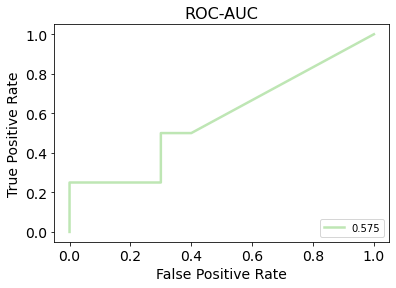

In [7]:
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["SMILES"], df["bin_act"], test_size=0.2)

mdl = MorganBinaryClassifier()
mdl.fit(X_train, y_train)
y_pred = mdl.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
#plt.savefig(os.path.join("../figures", "roc_auto6.png"))

In [8]:
mdl._auroc

0.9627777777777777

In [4]:
import joblib
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier

#Train model with all data
X = df["SMILES"]
y = df["bin_act"]

mdl = MorganBinaryClassifier()
mdl.fit(X, y)
joblib.dump(mdl,"../models/morganclf.joblib")

[flaml.automl: 06-12 20:53:17] {2365} INFO - task = classification
[flaml.automl: 06-12 20:53:17] {2367} INFO - Data split method: stratified
[flaml.automl: 06-12 20:53:17] {2371} INFO - Evaluation method: cv
[flaml.automl: 06-12 20:53:17] {1195} INFO - class 1 augmented from 16 to 32
[flaml.automl: 06-12 20:53:17] {2448} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 06-12 20:53:17] {2561} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 06-12 20:53:17] {2853} INFO - iteration 0, current learner lgbm
[flaml.automl: 06-12 20:53:18] {2984} INFO - Estimated sufficient time budget=5873s. Estimated necessary time budget=135s.
[flaml.automl: 06-12 20:53:18] {3036} INFO -  at 0.6s,	estimator lgbm's best error=0.2424,	best estimator lgbm's best error=0.2424
[flaml.automl: 06-12 20:53:18] {2853} INFO - iteration 1, current learner lgbm
[flaml.automl: 06-12 20:53:18] {3036} INFO -  at 0.8s,	estimator lgbm's best

['../models/morganclf.joblib']

In [5]:
mdl._auroc

0.9558441558441558

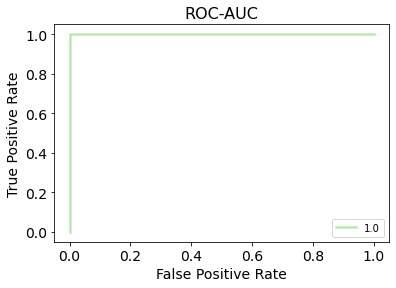

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt

#check model performance over real training data
y_pred = mdl.predict_proba(X)

fpr_test, tpr_test, _ = metrics.roc_curve(y, y_pred[:,1])
auc_test = metrics.roc_auc_score(y, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')

In [10]:
#Filter list of molecules for docking
dk = pd.read_csv("../data/docking/full_lib/smiles.smi", sep='\t', names=['smiles', 'id'])
smi = dk["smiles"]

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

preds = []
for chunk in chunker(smi, 10000):
    p = mdl.predict_proba(chunk)
    preds += [p]

In [28]:
proba1 = []
for x in preds:
    p1_chunk = x[:,1]
    # print(p1_chunk)

    proba1 += list(p1_chunk)
    

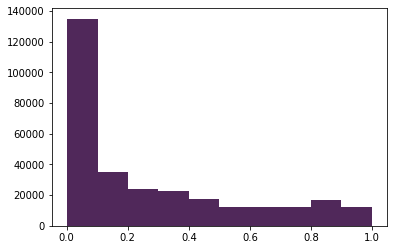

In [46]:
plt.hist(proba1, color = "#50285a")
plt.savefig("../figures/inhibitory_pred.png", dpi=300)

In [47]:
dk["proba1"]=proba1
dk.to_csv("../data/inhibitory_pred.csv", index=False)

In [54]:
len(dk[dk["proba1"]>= 0.99])

240

In [38]:
sorted = dk.sort_values("proba1", ascending=False )

In [40]:
top30 = sorted.head(30)
top30["smiles"].to_csv("../data/top30.csv")

In [57]:
down30 = sorted.tail(30)
down30["smiles"].to_csv("../data/down30.csv")